# Exploratory Data Analysis of Titanic Data with SingleStoreDB

This notebook uses the SingleStoreDB Python package to perform basic EDA for the Titanic survival data.
The **new No SQL** --> No Can See SQL.

In [1]:
import sys
sys.path.insert(0, '/home/ksmith/src/sqlalchemy-singlestore')
sys.path.insert(0, '/home/ksmith/src/ibis-singlestore')

In [2]:
import ibis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ibis.options.verbose = False   ## make this True to see the generated SQL
ibis.options.interactive = True

### Connect to SingleStoreDB

The connection parameters can either be [Python DB-API](https://peps.python.org/pep-0249/) style parameters, 
or a URL connection string as used by [SQLAlchemy](https://www.sqlalchemy.org).

In [4]:
conn = ibis.singlestoredb.connect('root:@127.0.0.1/x_db')

### Head over to Kaggle and get the csv files for the titanic data

https://www.kaggle.com/c/titanic

### Read the csv files for training and test data set 

- Pclass = Passenger Class (1=1st, 2=2nd, 3=3rd)
- Survived = Survival (1 = Yes, 0 = No)
- Sex = Gender
- Age = Passenger age
- Fare = Ticket price in British pounds
- SibSp  = # of siblings / spouses aboard the Titanic. 
- Parch  = # of parents / children aboard the Titanic.
- Embarked = Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- Cabin = Cabin No.

In [5]:
train_df = pd.read_csv('titanic_train.csv')
test_df = pd.read_csv('titanic_test.csv')

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
titanic_df = pd.concat([train_df, test_df])

### Create a table for the combined data in SingleStoreDB

We can use the `create_table` method of the connection to upload a pandas DataFrame to a database table.
The `force=True` is merely used here in case you run the same notebook multiple times. It will cause the 
table in the database to be overwritten if it already exists.

In [9]:
titanic_df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Notice that the `Survived` column is a float64 in the DataFrame. The data in that column is actually boolean with possible NULLs.
Since we use it as a filtering column in many operations, we'll change the column to boolean using `schema_overrides` when it is uploaded.

In [10]:
titanic_tbl = conn.create_table('titanic', titanic_df, schema_overrides=dict(Survived='bool'), force=True)

In [11]:
titanic_tbl.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [12]:
titanic_tbl.info()

                     Summary of titanic                     
                         1309 rows                          
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Name        ┃ Type                   ┃ # Nulls ┃ % Nulls ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ PassengerId │ Int64(nullable=True)   │       0 │    0.00 │
│ Survived    │ Boolean(nullable=True) │     418 │   31.93 │
│ Pclass      │ Int64(nullable=True)   │       0 │    0.00 │
│ Name        │ String(nullable=True)  │       0 │    0.00 │
│ Sex         │ String(nullable=True)  │       0 │    0.00 │
│ Age         │ Float64(nullable=True) │     263 │   20.09 │
│ SibSp       │ Int64(nullable=True)   │       0 │    0.00 │
│ Parch       │ Int64(nullable=True)   │       0 │    0.00 │
│ Ticket      │ String(nullable=True)  │       0 │    0.00 │
│ Fare        │ Float64(nullable=True) │       1 │    0.08 │
│ Cabin       │ String(nullable=True)  │    1014 │   77.46 │
│ Embarked    │ String(n

### List of Ibis functions for numerical data

We will be using various methods on numeric columns of database tables in this notebook. This code simply
prints all of the methods on numeric columns for reference.

In [13]:
num_expr = titanic_tbl.Age
print(' '.join([x for x in dir(num_expr) if not x.startswith('_')]))

abs acos add approx_median approx_nunique arbitrary argmax argmin asin atan atan2 between bottomk bucket case cases cast ceil clip coalesce collect compile corr cos cot count cov cume_dist cummax cummean cummin cumsum deg2rad degrees dense_rank describe div equals execute exp fillna first floor floordiv get_name greatest group_concat has_name hash histogram identical_to isin isinf isnan isnull lag last lead least ln log log10 log2 max mean min mod mul name negate notin notnull nth ntile nullif nullifzero nunique op over parent percent_rank pipe point pow quantile rad2deg radd radians rank rdiv rfloordiv rmod rmul round rpow rsub sign sin sqrt std sub substitute sum summary tan to_projection topk type typeof value_counts var verify visualize zeroifnull


### Unique values for some columns in the table

In [14]:
titanic_tbl['Pclass', 'Sex', 'Ticket'].describe(stats=['unique'], include='all')  # Use include='all' to include character columns in statistics

,name,unique
0,Pclass,3
1,Sex,2
2,Ticket,929


### Simple statistics for numeric columns

In [15]:
titanic_tbl['SibSp', 'Parch', 'Age'].describe(stats=['min', 'mean', 'max'])

,name,mean,min,max
0,SibSp,0.498900,0,8
1,Parch,0.385000,0,9
2,Age,29.881138,0.17000000178813934,80


#### Set the verbose option to True if you want to see the generated SQL

In [16]:
ibis.options.verbose = False

### Overall Survival Rate

In [17]:
train = titanic_tbl.Survived.notnull()
num_surv = titanic_tbl[titanic_tbl.Survived].count()
num_pass = titanic_tbl[train].count()
num_surv / num_pass

0.3838383838

### Cross-classification of Gender and Survival

In [18]:
cols = [titanic_tbl.Sex, titanic_tbl.Survived]

freq = titanic_tbl[train].groupby(cols).aggregate(
    Passengers=titanic_tbl.count(),
    AvgAge=titanic_tbl.Age.mean(),
).sort_by(cols)

freq

,Sex,Survived,Passengers,AvgAge
0,female,False,81,25.046875
1,female,True,233,28.847716
2,male,False,468,31.618056
3,male,True,109,27.276022


#### Join with the gender-specific counts

In [19]:
gender = titanic_tbl[train].groupby(titanic_tbl.Sex).count(metric_name='Count').relabel(dict(Sex='Sex_'))  # Relabel to avoid duplicate name in result
joined = freq.join(gender, freq.Sex == gender.Sex_).drop('Sex_')
joined

,Sex,Survived,Passengers,AvgAge,Count
0,female,False,81,25.046875,314
1,female,True,233,28.847716,314
2,male,False,468,31.618056,577
3,male,True,109,27.276022,577


#### Calculate the percentages overall and within each gender

In [20]:
# Get the total as a local numeric to use in the following expressions.
# Downloading the value is needed because it originates from a separate table expression.
total_int = titanic_tbl[train].count().execute()

# Add additional columns to joined table and execute to download the data for plotting.
joined = joined.mutate(
    OverallPercent=100.0 * joined.Passengers / total_int,
    GroupPercent=100.0 * joined.Passengers / joined.Count,
)

joined

,Sex,Survived,Passengers,AvgAge,Count,GroupPercent,OverallPercent
0,female,False,81,25.046875,314,25.796178,9.090909
1,female,True,233,28.847716,314,74.203822,26.150393
2,male,False,468,31.618056,577,81.109185,52.525253
3,male,True,109,27.276022,577,18.890815,12.233446


#### Draw a nested barplot by sex and survival

Plotting the data requires us to download the data into a pandas `DataFrame`. The `execute` method is used to 
execute the query behind the `joined` object and return a local `DataFrame` of the values.

In [21]:
joined_df = joined.execute()

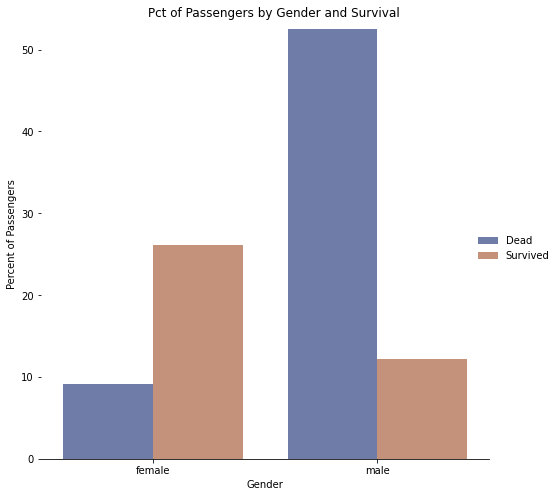

In [21]:
g = sns.catplot(
    data=joined_df, kind='bar',
    x='Sex', y='OverallPercent', hue='Survived',
    palette='dark', alpha=.6, height=7
)

g.despine(left=True)
g.set_axis_labels('Gender', 'Percent of Passengers')
g.legend.set_title('')

new_labels = ['Dead', 'Survived']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)
    
g.fig.suptitle('Pct of Passengers by Gender and Survival');

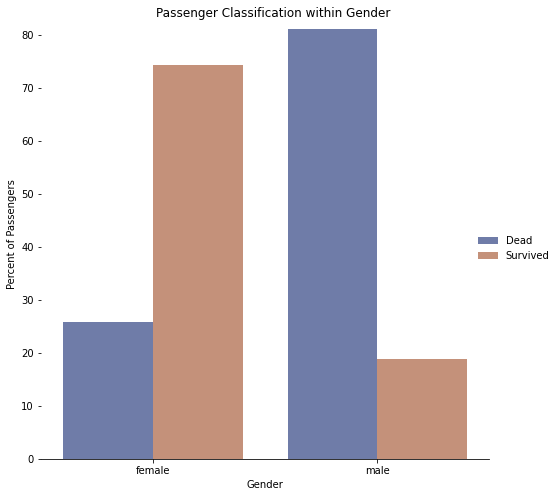

In [22]:
g = sns.catplot(
    data=joined_df, kind='bar',
    x='Sex', y='GroupPercent', hue='Survived',
    palette='dark', alpha=.6, height=7
)

g.despine(left=True)
g.set_axis_labels('Gender', 'Percent of Passengers')
g.legend.set_title('')

new_labels = ['Dead', 'Survived']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

g.fig.suptitle('Passenger Classification within Gender');

### Survival by Passenger Class

In [23]:
cols = [titanic_tbl.Pclass, titanic_tbl.Survived]

freq = titanic_tbl[train].groupby(cols).aggregate(
    Passengers=titanic_tbl.count(),
    AvgAge=titanic_tbl.Age.mean(),
).sort_by(cols)

freq

,Pclass,Survived,Passengers,AvgAge
0,1,False,80,43.695312
1,1,True,136,35.368197
2,2,False,97,33.544444
3,2,True,87,25.901566
4,3,False,372,26.555556
5,3,True,119,20.646118


In [24]:
passenger = titanic_tbl[train].groupby(titanic_tbl.Pclass).count(metric_name='Count').relabel(dict(Pclass='Pclass_'))
joined = freq.join(passenger, freq.Pclass == passenger.Pclass_).drop('Pclass_')

joined = joined.mutate(
    OverallPercent=100.0 * joined.Passengers / total_int,
    GroupPercent=100.0 * joined.Passengers / joined.Count,
)

joined

,Pclass,Survived,Passengers,AvgAge,Count,GroupPercent,OverallPercent
0,1,False,80,43.695312,216,37.037037,8.978676
1,1,True,136,35.368197,216,62.962963,15.263749
2,2,False,97,33.544444,184,52.717391,10.886644
3,2,True,87,25.901566,184,47.282609,9.764310
4,3,False,372,26.555556,491,75.763747,41.750842
5,3,True,119,20.646118,491,24.236253,13.355780


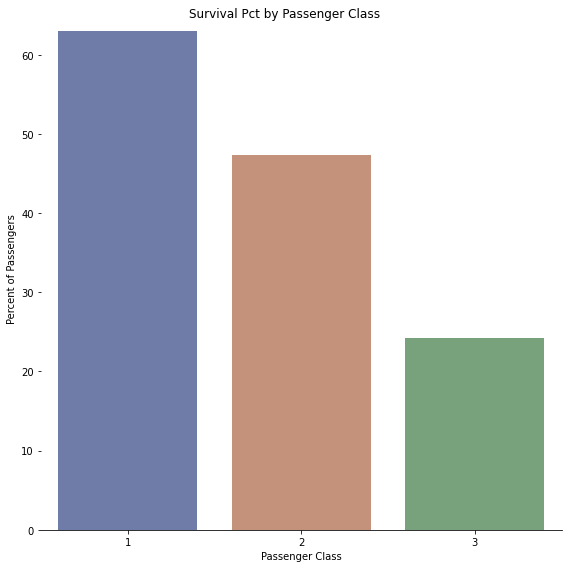

In [25]:
survived_df = joined[joined.Survived].execute()

g = sns.catplot(
    data=survived_df,
    kind='bar',
    x='Pclass', y='GroupPercent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Passenger Class', 'Percent of Passengers')
g.fig.suptitle('Survival Pct by Passenger Class');

### Analyze Age Groups

In [26]:
buckets = list(range(-10, 90, 10))
group = 'AgeGroup'

bucketed = titanic_tbl.Age.bucket(buckets).name(group).value_counts(metric_name='Count')

labeled_bucket = bucketed[group].label(
    ['None', '< 10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
).name('Ages')

expr = bucketed[labeled_bucket, bucketed]
expr = expr.mutate(
    Percent=100.0 * expr.Count / expr.Count.sum(),
).sort_by(group)

expr

,Ages,AgeGroup,Count,Percent
0,None,NaN,263,20.091673
1,< 10,1.0,82,6.264324
2,11-20,2.0,143,10.924370
3,21-30,3.0,344,26.279603
4,31-40,4.0,232,17.723453
5,41-50,5.0,135,10.313216
6,51-60,6.0,70,5.347594
7,61-70,7.0,32,2.444614
8,71-80,8.0,8,0.611154


In [27]:
expr_df = expr.execute()

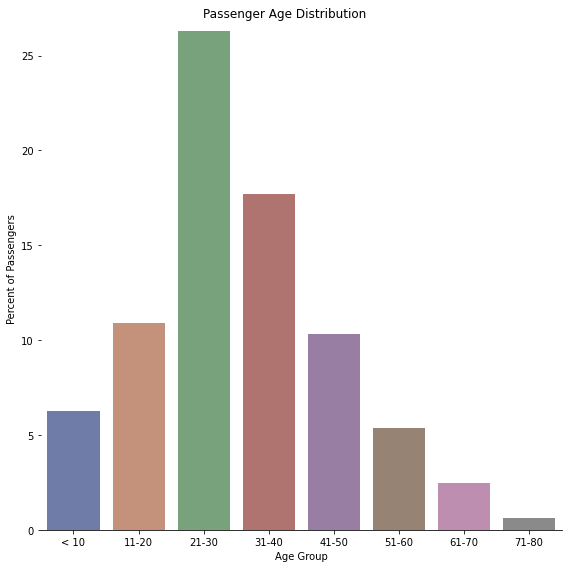

In [28]:
g = sns.catplot(
    data=expr_df, 
    kind='bar',
    x='Ages', y='Percent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Age Group', 'Percent of Passengers')
g.fig.suptitle('Passenger Age Distribution');

In [29]:
buckets = list(range(-10, 90, 10))
group = 'AgeGroup'

bucketed = titanic_tbl[titanic_tbl.Survived == 1].Age.bucket(buckets).name(group).value_counts(metric_name='Count')

labeled_bucket = bucketed[group].label(
    ['NaN', '< 10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
).name('Ages')

expr = bucketed[labeled_bucket, bucketed]
expr = expr.mutate(
    Percent=100.0 * expr.Count / expr.Count.sum(),
).sort_by(group)

expr

,Ages,AgeGroup,Count,Percent
0,None,NaN,52,15.204678
1,< 10,1.0,38,11.111111
2,11-20,2.0,41,11.988304
3,21-30,3.0,77,22.514620
4,31-40,4.0,73,21.345029
5,41-50,5.0,34,9.941520
6,51-60,6.0,20,5.847953
7,61-70,7.0,6,1.754386
8,71-80,8.0,1,0.292398


In [30]:
expr_df = expr.execute()

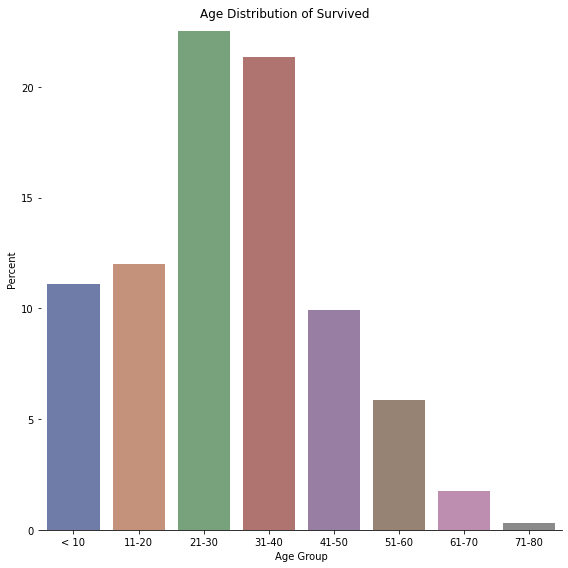

In [31]:
g = sns.catplot(
    data=expr_df, 
    kind='bar',
    x='Ages', y='Percent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Age Group', 'Percent')
g.fig.suptitle('Age Distribution of Survived');